# Kohonen - Iris

- Aluno: Patrick Pires
- Matricula: 201810037211

In [1]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.datasets import load_iris

## Carregando Dados

In [2]:
data_x, data_y = load_iris(return_X_y=True)
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

## Definições

In [3]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [4]:
def train(train_x, map_size, max_learning_rate, n_iterations, sigma_0, show_progress_each=None):
  num_rows = num_cols = map_size
  train_x_norm = minmax_scaler(train_x) # normalisation

  # initialising self-organising map
  num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
  np.random.seed(40)
  som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

  # start training iterations
  for step in range(n_iterations):
    if (show_progress_each is not None) and ((step+1) % show_progress_each == 0):
      print("Iteration: ", step+1) # print out the current iteration for every 1k
    learning_rate, neighbourhood_range = decay(step, n_iterations, max_learning_rate, sigma_0)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
      for col in range(num_cols):
        if m_distance([row,col],winner) <= neighbourhood_range:
          som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

  return som, train_x_norm

In [5]:
# collecting labels

def collect_labels(train_y, map_size, train_x_norm, som):
  num_rows = num_cols = map_size
  label_data = train_y
  map = np.empty(shape=(num_rows, num_cols), dtype=object)

  for row in range(num_rows):
    for col in range(num_cols):
      map[row][col] = [] # empty list to store the label

  for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
      print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
  
  return map


In [6]:
# construct label map

def get_label_map(map_size, map,):
  num_rows = num_cols = map_size
  label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
  for row in range(num_rows):
    for col in range(num_cols):
      label_list = map[row][col]
      if len(label_list)==0:
        label = 2
      else:
        label = max(label_list, key=label_list.count)
      label_map[row][col] = label
  return label_map

def show_label_maps(label_maps, titles):
  n = len(label_maps)
  fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
  if n == 1:
    axes = [axes]
  cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
  for i, (label_map, title) in enumerate(zip(label_maps, titles)):
    ax = axes[i]
    im = ax.imshow(label_map, cmap=cmap)
    ax.set_title(title)
    # Annotate each cell with its label value
    for (row, col), label in np.ndenumerate(label_map):
      ax.text(col, row, str(label), ha='center', va='center', color='black', fontsize=12)
    fig.colorbar(im, ax=ax)
  plt.tight_layout()
  plt.show()

In [7]:
def accuracy(test_x, som, map_size, label_map):
    num_rows = num_cols = map_size
    data = minmax_scaler(test_x) # normalisation

    winner_labels = []

    for t in range(data.shape[0]):
        winner = winning_neuron(data, t, som, num_rows, num_cols)
        row = winner[0]
        col = winner[1]
        predicted = label_map[row][col]
        winner_labels.append(predicted)

    accu = accuracy_score(test_y, np.array(winner_labels))
    return accu

In [8]:
def execute_experiment(scenarios):
    label_maps = []
    titles = []

    for scenario in scenarios:
        map_size = scenario['map_size']
        max_learning_rate = scenario['max_learning_rate']
        n_iterations = scenario['n_iterations']
        sigma_0 = scenario['sigma_0']

        som, train_x_norm = train(train_x, map_size, max_learning_rate, n_iterations, sigma_0)
        map = collect_labels(train_y, map_size, train_x_norm, som)
        label_map = get_label_map(map_size, map)
        accu = accuracy(test_x, som, map_size, label_map)

        label_maps.append(label_map)

        map_size_title = rf'${map_size}x{map_size}$'
        learning_rate_title = rf'$\alpha(t)={max_learning_rate}$'
        iterations_title = rf'$n={n_iterations}$'
        sigma_title = rf'$\sigma_0={sigma_0}$'
        accuracy_title = rf'accuracy: {int(accu*100)}%'

        titles.append(f'{map_size_title} | {learning_rate_title} | {iterations_title} | {sigma_title}\n{accuracy_title}')
    
    show_label_maps(label_maps, titles)

## Experimentos

Aproveitando a sugestão feita no slide de tutorial do trabalho, me basearei no mesmo para rodar os experimentos.

Em cada experimento, irei variar os seguintes parâmetros:
- Tamanho do mapa (map_size)
- Taxa de aprendizado (max_learning_rate)
- Número de iterações (n_iterations)
- Sigma inicial (sigma_0)

Um por vez. Por exemplo, no experimento 1, alterarei o tamanho do mapa para ver sua influência e fixarei os demais parâmetros.

Os valores que os mesmos assumirão serão:

| Parâmetro          | Valores         |
|--------------------|---------------|
| Tamanho do Mapa    | 5x5, 10x10, 15x15 |
| Taxa de Aprendizado | 0.5, 0.1, 0.01 |
| Número de Iterações | 1000, 5000, 10000, 30000, 50000 |
| Sigma Inicial      | 3, 5, 7 |

### Experimento 1: Tamanho do Mapa

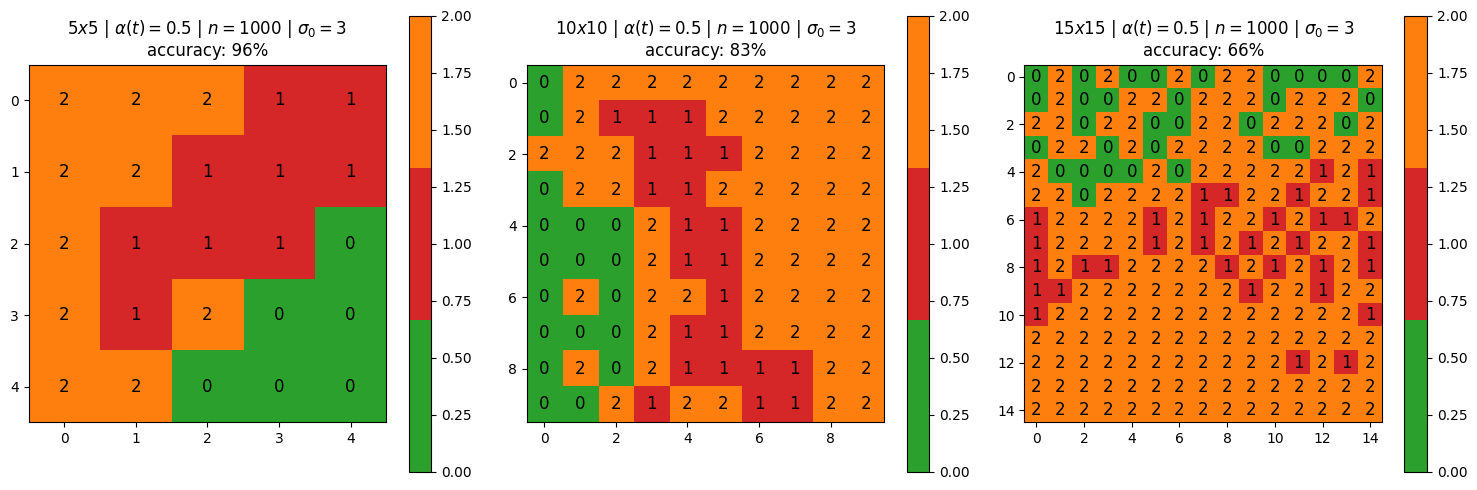

In [9]:
map_size_experiment = [
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 10, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 15, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3}
]
execute_experiment(map_size_experiment)

Nesse experimento, com um aumento do tamanho do mapa, é perceptível que a acurácia diminui e o agrupamento fica cada vez pior. Dentre as alterações, o tamanho $5\times5$ foi o que obteve a melhor acurácia, com $96\%$.

### Experimento 2: Taxa de Aprendizado

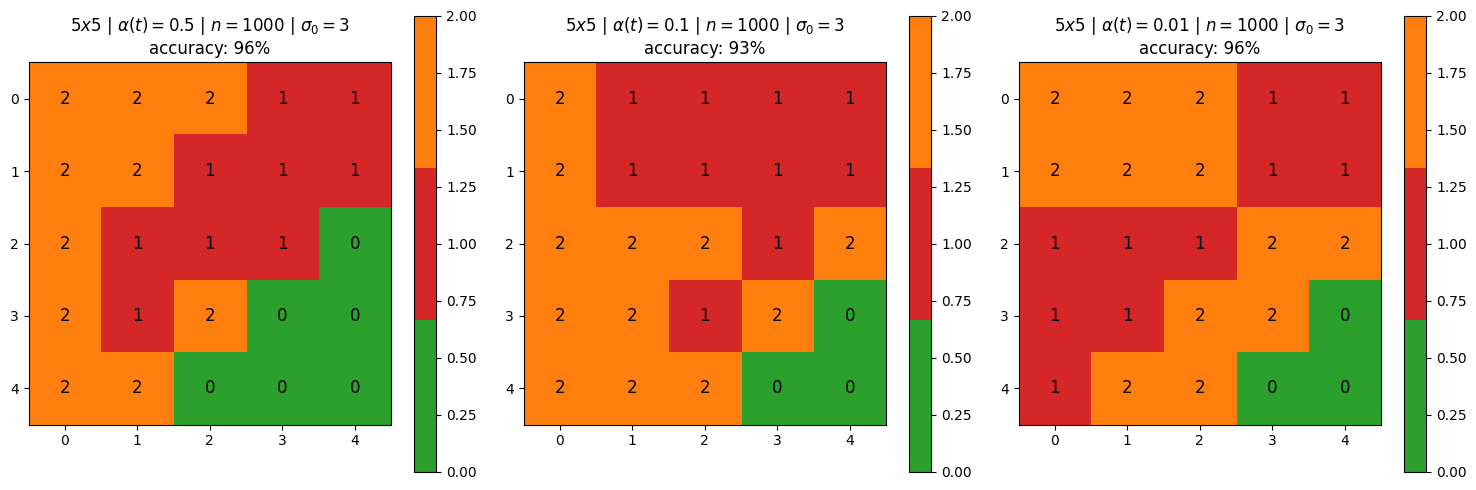

In [10]:
max_learning_rate_experiment = [
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.1, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.01, 'n_iterations': 1000, 'sigma_0': 3}
]
execute_experiment(max_learning_rate_experiment)

Nesse experimento, a acuracia cai no segundo cenário, mas volta para $96\%$ no terceiro cenário. Essa queda é de apenas $3\%$, então não é tão preocupante. E pode-se perceber que os agrupamentos entre os mapas são bem próximos.

### Experimento 3: Número de Iterações

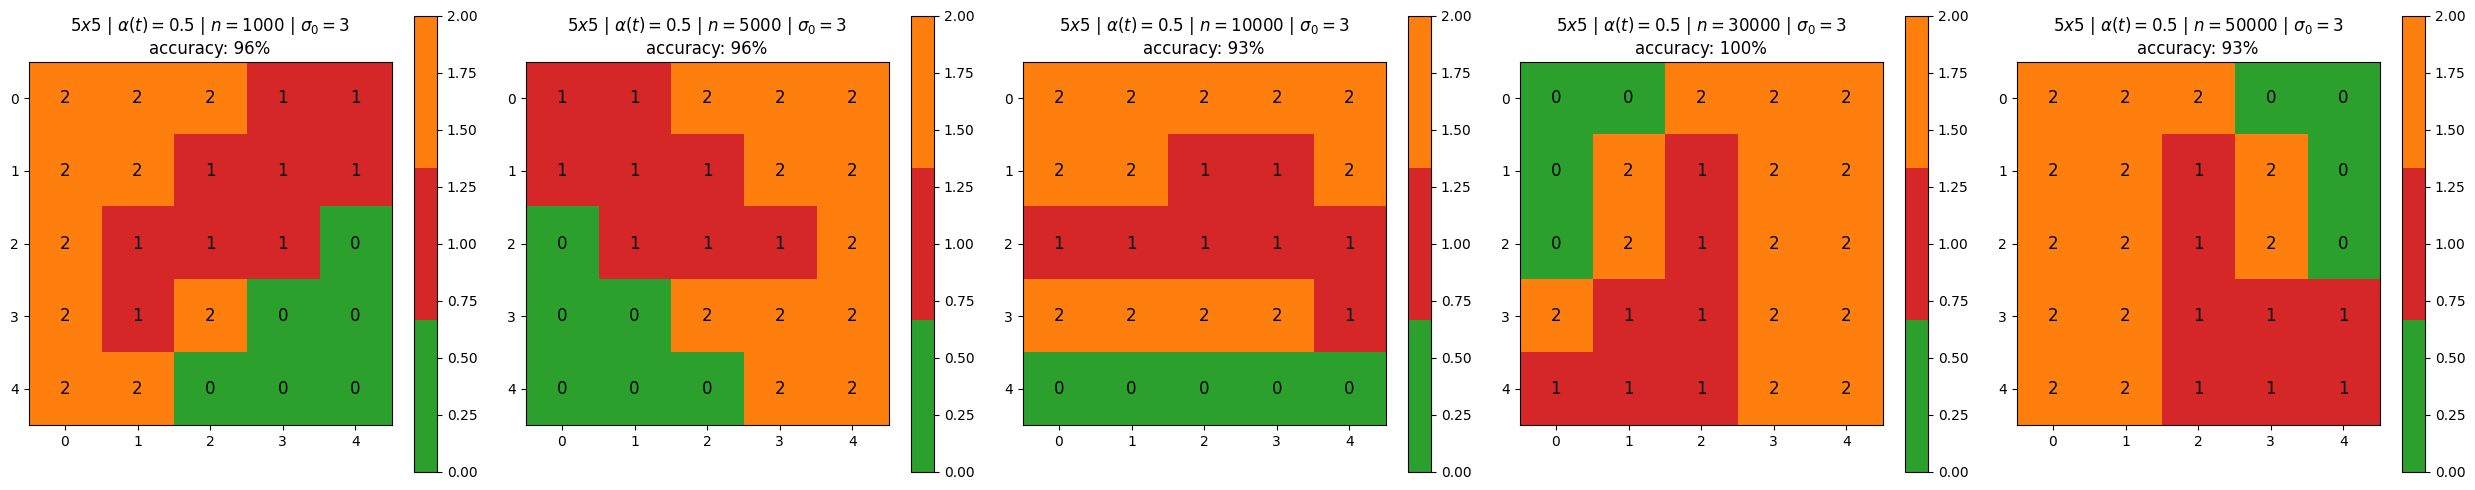

In [11]:
n_iterations_experiment = [
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 5000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 10_000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 30_000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 50_000, 'sigma_0': 3}
]
execute_experiment(n_iterations_experiment)

Nesse experimento, houve uma variabilidade de mapas bem maior, mas o resultado mais interessante foi que a acurácia de $100\%$ para $30.000$ iterações, o que mostra que o número de iterações é um fator importante para a acurácia do modelo.

### Experimento 4: Sigma Inicial

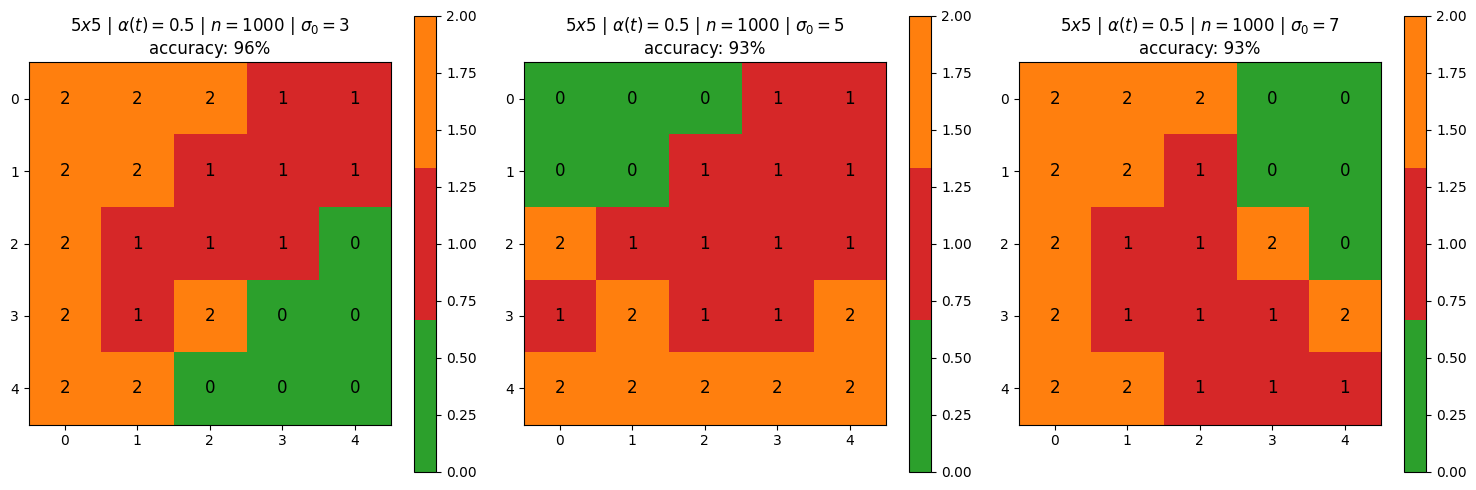

In [12]:
sigma_0_experiment = [
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 3},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 5},
    {'map_size': 5, 'max_learning_rate': 0.5, 'n_iterations': 1000, 'sigma_0': 7}
]
execute_experiment(sigma_0_experiment)

Nesse experimento, o aumento do sigma inicial abaixa a acurácia do modelo, mas, assim como os outros experimentos, não é uma queda tão grande. A acurácia foi de $96\%$ para $93\%$.

## Conclusão

Todas as alterações tem impacto na acurácia do modelo, mas o número de iterações e o tamanho do mapa são os que mais influenciaram para esses experimentos. Mais especificamente, aumentando o número de iterações para ajudar o modelo a aprender melhor e diminuindo o tamanho do mapa para que ele não fique tão grande e disperso, o que ajuda a manter os agrupamentos mais próximos.

Essa última afirmação sobre o tamanho do mapa, é claro, foi pensada para esses cenários de experimento. Não quer dizer que o menor mapa sempre será melhor, mas sim que, para esses dados, o tamanho $5\times5$ foi o melhor e ele é o menor dentre os testados.